In [1]:
# Packages
############################
'''
Template for the 4th assignment
Student: Fabian Gobet
'''
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import math
from accelerate import Accelerator
import random
import re
from nltk.tokenize.treebank import TreebankWordTokenizer
import statistics
import pickle
import os
import matplotlib.pyplot as plt
import collections
import itertools
import numpy as np
from torch.utils.data import DataLoader, random_split

/Users/fabiangobet/anaconda3/envs/pythonProject/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Classes
############################
# Vocabulary class
class Vocabulary:
    '''
    Class for dealing with our corpus
    '''

    def __init__(self, name, sentences):
        """
        Args:
            name (str): name of the language
            pairs (list): list of pairs of sentences
        """
        self.name = name
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        for s in sentences:
            self.add_sentence(s)


    def add_word(self, word):
        '''
        Add a word to the vocabulary
        :param word: a string
        '''
        # TODO: add the word to the vocabulary
        if not word in self.word2index:
            self.word2index[word] = len(self.word2index)
            self.index2word[len(self.index2word)] = word


    def add_sentence(self, sentence):
        '''
        Add a sentence to the vocabulary
        :param sentence: list of strings (words)
        '''
        # TODO add the sentence to the vocabulary, this method will call the add_word method
        for word in sentence:
            self.add_word(word)


# Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, vocabulary, pairs_refs, sentences):
        # TODO We want vocabulary and pairs to be attributes of the class
        self.vocabulary = vocabulary
        self.pairs = pairs_refs
        self.sentences = sentences

    def __len__(self):
        # TODO how many pairs do we have?
        return len(self.pairs)

    def __getitem__(self, ix):
        # TODO returns two tensors (question, answer) of the pair at index ix
        # TODO the tensors should be of type torch.tensor and should contain integers (word indices)
        q,a = self.pairs[ix]
        q = torch.tensor([self.vocabulary.word2index[word] for word in self.sentences[q]])
        a = torch.tensor([self.vocabulary.word2index[word] for word in self.sentences[a]])
        return q,a


class PositionalEncoding(nn.Module):
    '''
    Adapted from
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    '''
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        try:
            assert x.size(0) < self.max_len
        except:
            print("The length of the sequence is bigger than the max_len of the positional encoding. Increase the max_len or provide a shorter sequence.")
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, pad_id=0, encoder_layers=6, decoder_layers=6, dim_feedforward=2048, num_heads=8, dropout_transformer=0.1, dropout_posenconding=0):
        super().__init__()

        # TODO add an embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model,padding_idx=pad_id)

        # TODO add a positional encoding layer
        self.pos_encoder = PositionalEncoding(d_model,dropout=dropout_posenconding)

        # TODO add a transformer layer, you can use nn.Transformer. You can use the default values for the parameters, but what about batch_first?
        self.transformer = nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=encoder_layers, num_decoder_layers=decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout_transformer, batch_first=True)

        # TODO add a linear layer. Note: output should be probability distribution over the vocabulary
        self.linear = nn.Linear(d_model, vocab_size, bias=False)

        # Stuff you may need
        self.vocab_size = vocab_size
        self.pad_id = pad_id
        self.num_heads = num_heads

    def create_padding_mask(self, x, pad_id=0):
        # TODO create a boolean mask for the <PAD> tokens
        return x.eq(pad_id)

    def forward(self, src, tgt):
        # S is the source sequence length, T is the target sequence length, N is the batch size, E is the feature number
        # src: (N, S)
        # tgt: (N, T)
        # src_pad_mask: (N, S)
        # tgt_pad_mask: (N, T)
        # mask the future : (N * num_heads, T, T)

        src_pad_mask = self.create_padding_mask(src, self.pad_id) # (N, S)
        tgt_pad_mask = self.create_padding_mask(tgt, self.pad_id) # (N, T)

        src = self.embedding(src)
        tgt = self.embedding(tgt)

        src = self.pos_encoder(src)  # (N, S, E)
        tgt = self.pos_encoder(tgt) # (N, T, E)

        # Mask the memory
        memory_key_padding_mask = src_pad_mask  # (N, S)

        # Mask the future
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1), dtype=torch.bool).to(tgt.device) # (T, T)

        # Expand to make it N * num_heads, T, T
        tgt_mask = tgt_mask.unsqueeze(0).repeat(tgt.size(0) * self.num_heads, 1, 1) # (N, T, T)

        # Transformer
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask,tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=memory_key_padding_mask) # (N, T, E)
        # Linear layer
        output = self.linear(output) # (N, T, V)
        return output

class EarlyStopper:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def check_early_stop(self, current_loss, model):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [3]:
# Methods new
############################
def clear_punctuation(s):
    '''
    This function removes all the punctuation from a sentence and insert a blank between any letter and !?.
    :param s: a string
    :return: the "cleaned" string
    '''
    # Remove all the character that are not letters, puntuation or numbers
    s = re.sub(r"[^a-zA-Z.!?,']+", r" ", s)
    # Insert a blank between any letter and !?. using regex
    #s = re.sub(r"([a-zA-Z])([!?.])", r"\1 \2", s)
    return s


def pickle_dump(obj, PATH, name):
    '''
    Save an object to a pickle file
    :param obj: object to save
    :param path: path to the pickle file
    '''
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    with open(PATH+name, 'wb') as f:
        pickle.dump(obj, f)

def pickle_load(PATH):
    '''
    Load an object from a pickle file
    :param path: path to the pickle file
    :return: the loaded object
    '''
    with open(PATH, 'rb') as f:
        obj = pickle.load(f)
    return obj

def print_random_elements(collection, k=5):
    '''
    Print k random elements from a collection
    :param collection: list of elements
    :param k: number of elements to print
    '''
    random_elements = random.sample(collection, k=k)
    for e in random_elements:
        print(e)

def collate_fn(batch,pad_idx):
  data, targets = zip(*batch)
  padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=pad_idx)
  padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=pad_idx)
  return padded_data, padded_targets

def checkpoint(model,optimizer,path='./MyFiles/',save_name=None):
  dic = {
      'model_state' : model.state_dict(),
      'optimizer' : optimizer.state_dict()
  }
  if save_name is not None:
    torch.save(dic, path+save_name+".pt")
  return dic

def load_checkpoint(path):
    checkpoint = torch.load(path)
    model_state = checkpoint['model_state']
    optimizer_state = checkpoint['optimizer']
    return model_state,optimizer_state

def check_content_txt_files(convo_path, lines_path, num_elements):
    '''
    Check the content of the files
    :param convo_path: path to the movie_conversations.txt file
    :param lines_path: path to the movie_lines.txt file
    :param num_elements: number of elements to print
    '''
    # Inspect movie_conversations.txt
    with open(convo_path, 'r') as conv_file:
        for i in range(num_elements):
            line = conv_file.readline()

    # Inspect movie_lines.txt
    with open(lines_path, 'r') as lines_file:
        for i in range(num_elements):
            line = lines_file.readline()

def get_reference_pairs(convo_path):
    '''
    Get the reference pairs
    :return: a list of pairs of references of sentences
    '''
    ref_pairs = []
    with open(convo_path, 'r') as conv_file:
        for line in conv_file:
            conversation = line.strip().split(' +++$+++ ')[-1][1:-1].replace("'", "").split(",")
            for i in range(len(conversation) - 1):
                ref_pairs.append((conversation[i].strip(), conversation[i+1].strip()))
    return ref_pairs
    

def normalize_sentences(path_lines):
    lines_dict = {}
    empty_lines = 0
    with open(path_lines, 'r', encoding='cp1252') as lines_file:
        for full_line in lines_file:
            line_split = full_line.split(' +++$+++ ')
            line = line_split[-1]
            line, is_line = process_sentence(line)
            if is_line == 0:
                empty_lines += 1
            else:
                lines_dict.update({line_split[0] : line})
    return lines_dict, empty_lines

def process_sentence(line):
    is_line = 0
    line = line.replace('\n','').replace("<u>","").replace("</u>","").lower()
    line = re.sub('-+','',line)
    line = re.sub(r"[^a-zA-Z.!?,']+", r" ", line)
    line = re.sub(r"i'm", "i am", line, flags=re.I)
    line = re.sub(r"it's", "it is", line, flags=re.I)
    line = re.sub(r"he's", "he is", line, flags=re.I)
    line = re.sub(r"she's", "she is", line, flags=re.I)
    line = re.sub(r"can't", "can not", line, flags=re.I)
    line = re.sub(r"that's", "that is", line, flags=re.I)
    line = re.sub(r"there's", "there is", line, flags=re.I)
    line = re.sub(r"what's", "what is", line, flags=re.I)
    line = re.sub(r"where's", "where is", line, flags=re.I)
    line = re.sub(r"how's", "how is", line, flags=re.I)
    line = re.sub(r"\'ll", " will", line, flags=re.I)
    line = re.sub(r"\'s", " is", line, flags=re.I)
    line = re.sub(r"\'ve", " have", line, flags=re.I)
    line = re.sub(r"\'re", " are", line, flags=re.I)
    line = re.sub(r"\'d", " would", line, flags=re.I)
    line = re.sub(r"n't", " not", line, flags=re.I)
    line = re.sub(r"won't", "will not", line, flags=re.I)
    line = re.sub(r"can't", "cannot", line, flags=re.I)
    line = line.strip()
    if line == '' or line.isspace():
        is_line += 1
    else:
        line = TreebankWordTokenizer().tokenize(line)
    return line, is_line

def get_valid_refs(ref_pairs, lines):
    valid_refs = set()
    for p in ref_pairs:
        if p[0] in lines and p[1] in lines:
            valid_refs.add(p[0])
            valid_refs.add(p[1])
    return valid_refs

def generate_primitive_valid_pairs(all_ref_pairs, lines):
    chosen_sentences = {}
    chosen_ref_pairs = []

    for p in all_ref_pairs:
        if p[0] in lines and p[1] in lines:
            chosen_sentences.update({p[0]: lines[p[0]]+['<EOS>']})
            chosen_sentences.update({p[1]: ['<SOS>']+lines[p[1]]+['<EOS>']})  
            chosen_ref_pairs.append(p)
    return chosen_sentences, chosen_ref_pairs

def eliminate_long_sentences(chosen_sentences, chosen_ref_pairs, max_length):
    rule_out_sentences_refs = set()
    chosen_sentences2 = {}
    chosen_ref_pairs2 = []

    for k,v in chosen_sentences.items():
        if len(v) > max_length:
            rule_out_sentences_refs.add(k)

    for p in chosen_ref_pairs:
        if p[0] not in rule_out_sentences_refs and p[1] not in rule_out_sentences_refs:
            chosen_sentences2.update({p[0]: chosen_sentences[p[0]]})
            chosen_sentences2.update({p[1]: chosen_sentences[p[1]]})
            chosen_ref_pairs2.append(p)

    return chosen_sentences2,chosen_ref_pairs2,rule_out_sentences_refs

def eliminate_sentences_with_rare_words(chosen_sentences, chosen_ref_pairs, rule_out_words):
    rule_out_sentences_refs = set()
    chosen_sentences2 = {}
    chosen_ref_pairs2 = []

    for k,v in chosen_sentences.items():
        if any(word in rule_out_words for word in v):
            rule_out_sentences_refs.add(k)

    for p in chosen_ref_pairs:
        if p[0] not in rule_out_sentences_refs and p[1] not in rule_out_sentences_refs:
            chosen_sentences2.update({p[0]: chosen_sentences[p[0]]})
            chosen_sentences2.update({p[1]: chosen_sentences[p[1]]})
            chosen_ref_pairs2.append(p)

    return chosen_sentences2,chosen_ref_pairs2,rule_out_sentences_refs

def count_words(chosen_ref_pairs, chosen_sentences):
    word_counts = {}
    for p in chosen_ref_pairs:
        for r in p:
            for w in chosen_sentences[r]:
                if w in word_counts:
                    word_counts[w] += 1
                else:
                    word_counts[w] = 1
    num_words = sum(word_counts.values())
    return word_counts, num_words


def extract_sentences_from_refs(chosen_ref_pairs, chosen_sentences):
    chosen_sentences2 = {}
    for p in chosen_ref_pairs:
        chosen_sentences2.update({p[0]: chosen_sentences[p[0]]})
        chosen_sentences2.update({p[1]: chosen_sentences[p[1]]})
    return chosen_sentences2 



def prime_factors(n):
    i = 2
    while i * i <= n:
        if n % i == 0:
            n /= i
            yield i
        else:
            i += 1
    if n > 1:
        yield n


def prod(iterable):
    result = 1
    for i in iterable:
        result *= i
    return result


def get_divisors(n):
    pf = prime_factors(n)

    pf_with_multiplicity = collections.Counter(pf)

    powers = [
        [factor ** i for i in range(count + 1)]
        for factor, count in pf_with_multiplicity.items()
    ]

    for prime_power_combo in itertools.product(*powers):
        yield prod(prime_power_combo)


def create_pairs(path='./MyFiles/',savename="result",max_length=26,word_frequency_discard=10,verbose=True):

    if verbose:
        check_content_txt_files('./Data/movie_conversations.txt', './Data/movie_lines.txt', 5)

    all_ref_pairs = get_reference_pairs('./Data/movie_conversations.txt')

    if verbose:
        print_random_elements(all_ref_pairs)

    lines,empty_lines = normalize_sentences('./Data/movie_lines.txt')

    if verbose:
        print('Number of empty lines: {}'.format(empty_lines))
        print_random_elements(list(lines.values()))

    chosen_sentences, chosen_ref_pairs = generate_primitive_valid_pairs(all_ref_pairs, lines)

    if verbose:
        print_random_elements(chosen_ref_pairs)

        # Filter out the sentences that are too long
        # Compute the length of each sentence
        # Compute the mean and standard deviation for sentence lengths
        sentence_lengths = []
        for p in chosen_ref_pairs:
            sentence_lengths.append(len(chosen_sentences[p[0]]))
            sentence_lengths.append(len(chosen_sentences[p[1]]))

        mean_length = statistics.mean(sentence_lengths)
        std_dev = statistics.stdev(sentence_lengths)

        print('Mean sentence length: {}'.format(mean_length))
        print('Standard deviation: {}'.format(std_dev))
        print('Max sentence length: {}'.format(max(sentence_lengths)))
        print('Min sentence length: {}'.format(min(sentence_lengths)))

        # Plot the histogram with logarithmic scale on the y-axis
        plt.hist(sentence_lengths, density=True, bins=40)
        plt.xlabel('Sentence Length')
        plt.ylabel('Frequency (log scale)')
        plt.title('Sentence Length Distribution')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.axvline(x=mean_length, color='r', linestyle='--', label='Mean')  # Add vertical line for the mean
        plt.legend()
        plt.show()

        # Compute the frequency of each sentence length
        length_counts = {}
        for length in sentence_lengths:
            if length in length_counts:
                length_counts[length] += 1
            else:
                length_counts[length] = 1

        # Sort the sentence lengths in ascending order
        sorted_lengths = sorted(length_counts.keys())

        # Compute the accumulated frequency percentage
        total_sentences = len(sentence_lengths)
        accumulated_percentage = 0
        percentage_values = []
        for length in sorted_lengths:
            frequency = length_counts[length]
            percentage = (frequency / total_sentences) * 100
            accumulated_percentage += percentage
            percentage_values.append(accumulated_percentage)

        # Plot the sentence lengths and their accumulated frequency percentage
        plt.plot(sorted_lengths, percentage_values)
        plt.xlabel('Sentence Length')
        plt.ylabel('Accumulated Frequency Percentage')
        plt.title('Sentence Length Distribution')
        plt.show()

    initial_num_sentences = len(chosen_sentences)
    initial_num_pairs = len(chosen_ref_pairs)
    chosen_sentences,chosen_ref_pairs,rule_out_sentences_refs = eliminate_long_sentences(chosen_sentences, chosen_ref_pairs, max_length) 

    if verbose:
        print('Initial number of sentences: {}'.format(initial_num_sentences))
        print('Current number of senteces: {}'.format(initial_num_sentences-len(rule_out_sentences_refs)))
        print('Initial number of pairs: {}'.format(initial_num_pairs))
        print('Current number of pairs: {}'.format(initial_num_pairs-len(chosen_ref_pairs)))


    word_counts, num_words = count_words(chosen_ref_pairs, chosen_sentences)

    if verbose:
        print('Number of words: {}'.format(num_words))
        print('Number of unique words: {}'.format(len(word_counts)))

        plt.plot(range(len(word_counts)), list(word_counts.values()))
        plt.xlabel('Word index')
        plt.ylabel('Word frequency')
        plt.suptitle('Word frequency distribution')
        plt.title('Frequency per word')
        plt.show()

        # Compute the mean and standard deviation for word counts
        mean_value = statistics.mean(word_counts.values())
        print("Mean value:", mean_value)
        print("Max value:", max(word_counts.values()))
        print("Min value:", min(word_counts.values()))

        # Plot the distribution of word counts < mean
        dict_lower_mean = {k: v for k, v in word_counts.items() if v < mean_value}
        sorted_dict_lower_mean = dict(sorted(dict_lower_mean.items(), key=lambda x: x[1], reverse=True))

        plt.plot(range(len(sorted_dict_lower_mean)), sorted_dict_lower_mean.values())
        plt.xlabel('Word index')
        plt.ylabel('Word count')
        plt.suptitle('Word count distribution')
        plt.title('Words with count < mean')
        plt.show()

    # Frequency threshold and filter out the words that are too rare
    rule_out_words = [k for k, v in word_counts.items() if v < word_frequency_discard]
    chosen_sentences,chosen_ref_pairs,rule_out_sentences_refs = eliminate_sentences_with_rare_words(chosen_sentences, chosen_ref_pairs, rule_out_words)

    if verbose:
        print('Current number of senteces: {} ({:.2f}% of total)'.format(initial_num_sentences-len(chosen_sentences),(initial_num_sentences-len(chosen_sentences))/initial_num_sentences*100))
        print('Current number of pairs: {} ({:.2f}% of total)'.format(initial_num_pairs-len(chosen_ref_pairs),(initial_num_pairs-len(chosen_ref_pairs))/initial_num_pairs*100))

    # Save the pairs to a pickle file


    pickle_dump(chosen_sentences,path,savename+"_sentences.pkl")
    pickle_dump(chosen_ref_pairs,path,savename+"_ref_pairs.pkl")

    return chosen_sentences,chosen_ref_pairs


def train(epochs,model,optimizer,criterion,train_loader,val_loader,stopper,device,lr_scheduler,eval_period,clip=1.0):
    train_losses, val_losses = [],[]
    vocab = train_loader.dataset.vocabulary

    for epoch in range(epochs):
        model.train()
        for i, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(data,targets[:,:-1])
            loss = criterion(output.view(-1,output.size(-1)),targets[:,1:].contiguous().view(-1))
            loss.backward()
            if clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
            optimizer.step()
            if (i+1)%eval_period==0 or i==len(train_loader)-1:
                train_losses.append(loss.item())

                r_index = random.randint(0, len(data) - 1)
                r_target = targets[r_index].view(-1).cpu().detach().numpy()
                r_output = output[r_index].argmax(dim=-1).view(-1).cpu().detach().numpy()

                # Evaluation
                val_losses.append(evaluate(model, criterion, val_loader, device))
                print("Epoch: {}/{}, Batch: {}/{}:\n- Train Loss: {:.4f}".format(epoch+1,epochs,i,len(train_loader),train_losses[-1]))
                print("- Validation Loss: {:.4f}\n".format(val_losses[-1]))
                print("- Target: "+" ".join([vocab.index2word[i] for i in r_target]))
                print("- Output: "+" ".join([vocab.index2word[i] for i in r_output]))

        lr_scheduler.step()
        if  stopper.check_early_stop(val_losses[-1], model):
            print("Early stopping")
            break
    return train_losses, val_losses, model, stopper



def evaluate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            output = model(data, targets[:, :-1])
            loss = criterion(output.view(-1, output.size(-1)), targets[:, 1:].contiguous().view(-1))
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)



def train_ga(epochs, model, optimizer, criterion, train_loader, val_loader, stopper, device, lr_scheduler, print_every_n, accumulation_steps, vocab, clip=1.0):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        steps = 0

        for i, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()

            output = model(data, targets[:, :-1])
            loss = criterion(output.view(-1, output.size(-1)), targets[:, 1:].contiguous().view(-1))
            loss.backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0:
                if clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                lr_scheduler.step()
                total_loss += loss.item()
                steps += 1

                if (i + 1) % print_every_n == 0:
                    avg_loss = total_loss / steps
                    train_losses.append(avg_loss)
                    total_loss = 0.0
                    steps = 0
                    val_losses.append(evaluate(model, criterion, val_loader, device))

                    r_index = random.randint(0, len(data) - 1)
                    r_target = targets[r_index].view(-1).cpu().detach().numpy()
                    r_output = output[r_index].argmax(dim=-1).view(-1).cpu().detach().numpy()
                    print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}]\n- Train Loss: {avg_loss:.4f}")
                    print(f"- Validation Loss: {val_losses[-1]:.4f}")
                    print("- Target: "+" ".join([vocab.index2word[i] for i in r_target if i!=0]))
                    print("- Output: "+" ".join([vocab.index2word[i] for i in r_output])+"\n")
                    



        if  stopper.check_early_stop(val_losses[-1], model):
            print("Early stopping")
            break

    return train_losses, val_losses, model, stopper



def inference(model, test_sentence, vocab, device, greedy=True):

    line,_ = process_sentence(test_sentence)
    line = line + ['<EOS>']
    line = torch.tensor([vocab.word2index[word] for word in line]).unsqueeze(0)
    target = torch.tensor([vocab.word2index["<SOS>"]]).unsqueeze(0)

    with torch.no_grad():
        model.eval()
        line,target= line.to(device), target.to(device)
        for _ in range(20):
            output = model(line,target)
            if greedy:
                next_word_idx = output.argmax(dim=-1)[:,-1].unsqueeze(1)
            else:
                next_word_idx = torch.multinomial(F.softmax(output,dim=-1)[:,-1],1)
            target = torch.cat((target, next_word_idx), dim=1)
            if next_word_idx.item() == vocab.word2index["<EOS>"]:
                break
  
        line = line.view(-1).detach().cpu().numpy()
        target = target.view(-1).detach().cpu().numpy()
        print("Input:")
        [print(vocab.index2word[i.item()],end=" ") for i in line]
        print("\nOutput:")
        [print(vocab.index2word[i.item()],end=" ") for i in target]

def train_ga_hf(epochs, model, optimizer, criterion, train_loader, val_loader, device, lr_scheduler, accumulation_steps):
    accelerator = Accelerator(gradient_accumulation_steps=accumulation_steps)
    model, optimizer, train_loader, lr_scheduler = accelerator.prepare(model, optimizer, train_loader, lr_scheduler)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for i, (data, targets) in enumerate(train_loader):
            with accelerator.accumulate(model):
                data, targets = data.to(device), targets.to(device)
                output = model(data, targets[:, :-1])
                loss = criterion(output.view(-1, output.size(-1)), targets[:, 1:].contiguous().view(-1))
                train_losses.append(loss.item())
                accelerator.backward(loss)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

                # Print training progress
                if i+1 % 100 == 0 or i == len(train_loader)-1:
                    val_loss = evaluate(model, val_loader, criterion, device)
                    val_losses.append(val_loss)
                    print("Epoch: {}/{}, Batch: {}/{}:\n- Train Loss: {:.4f}".format(epoch + 1, epochs, i+1, len(train_loader), train_losses[-1]))
                    print("- Validation Loss: {:.4f}\n".format(val_loss))

    return train_losses, val_losses, model

In [4]:
# Load pairs
############################
PATH = './MyFiles/'
#chosen_sentences,chosen_ref_pairs = create_pairs(path='./MyFiles/',savename="result",max_length=26,word_frequency_discard=10,verbose=True)
chosen_sentences = pickle_load(PATH+'result_sentences.pkl')
chosen_ref_pairs = pickle_load(PATH+'result_ref_pairs.pkl')


In [5]:
# Dump QA 
############################
PATH = './MyFiles/'
with open(PATH+'qa_dump.txt', 'w') as qa_dump:
    for p in chosen_ref_pairs:
        q = " ".join(chosen_sentences[p[0]])
        a = " ".join(chosen_sentences[p[1]])
        qa_dump.write("Q: "+q+"\nA: "+a+"\n\n")

In [5]:
# Pipeline parameters
############################

# Hyperparameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
batch_size = 256
accumulation_steps = 4
rand_sample_num = 40960
learning_rate = 1e-3
d_model = 768
encoder_layers = 6
decoder_layers = 6
feed_forward_dim = 2048
nheads = 8
dropout_transformer = 0.2
dropout_posenconding = 0
patience = 3
epochs = 2
weight_decay = 0



# Randomly sample pairs and splits
rand_sample_num = min(rand_sample_num,len(chosen_ref_pairs))
chosen_ref_pairs = random.sample(chosen_ref_pairs,rand_sample_num)
grad_size = batch_size*accumulation_steps
train_size = (int(0.8 * rand_sample_num)//grad_size)*grad_size
val_size = (rand_sample_num-train_size)//2
test_size = rand_sample_num-train_size-val_size
train_pairs, test_pairs, val_pairs = random_split(chosen_ref_pairs,[train_size,val_size,test_size])

# Vocabulary, Dataset and Dataloader
vocab = Vocabulary("English",chosen_sentences.values())
train_dataset = Dataset(vocab,train_pairs,extract_sentences_from_refs(train_pairs, chosen_sentences))
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))
val_dataset = Dataset(vocab,val_pairs,extract_sentences_from_refs(val_pairs, chosen_sentences))
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))

In [6]:
# Pipeline initialization
############################

# Model, criterion, optimizer and scheduler
model = TransformerModel(vocab_size=len(vocab.word2index),d_model=d_model,pad_id=vocab.word2index["<PAD>"],
                         encoder_layers=encoder_layers,decoder_layers=decoder_layers,dim_feedforward=feed_forward_dim,
                         num_heads=nheads,dropout_transformer=dropout_transformer, dropout_posenconding=dropout_posenconding).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95, verbose=False)
stopper = EarlyStopper(patience=patience)


In [ ]:
# Standard Training
############################
eval_period = 8
train_losses, val_losses, model, stopper = train(epochs,model,optimizer,criterion,train_loader,val_loader,stopper,device,lr_scheduler,eval_period,clip=1.0)

In [ ]:
# Plot train losses and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Checkpointing
############################

PATH = './MyFiles/'
#save_checkpoint = checkpoint(model,optimizer,path=PATH,save_name="checkpoint_dicts")
#torch.save(model, PATH+'model.pt')
#model_state, optimizer_state = load_checkpoint(PATH+"checkpoint_dicts.pt")
#pickle_dump(train_losses,PATH,"train_losses.pkl")
#pickle_dump(val_losses,PATH,"val_losses.pkl")

model = torch.load(PATH+'model.pt')
train_losses = pickle_load(PATH+"train_losses.pkl")
val_losses = pickle_load(PATH+"val_losses.pkl")

In [ ]:
# Test loss
############################

model.eval()
test_loss = 0.0

testing_loader = DataLoader(Dataset(vocab,test_pairs,extract_sentences_from_refs(test_pairs,chosen_sentences)),batch_size=batch_size,
                            shuffle=True,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))

with torch.no_grad():
    for data, targets in testing_loader:
        data, targets = data.to(device), targets.to(device)
        output = model(data, targets[:, :-1])
        loss = criterion(output.view(-1, output.size(-1)), targets[:, 1:].contiguous().view(-1))
        test_loss += loss.item()

test_loss /= len(testing_loader)
print("Test Loss: {:.4f}".format(test_loss))


In [18]:
# Inference
############################
testing_loader = DataLoader(Dataset(vocab,test_pairs,extract_sentences_from_refs(test_pairs,chosen_sentences)),batch_size=1,
                            shuffle=True,collate_fn=lambda batch: collate_fn(batch,vocab.word2index["<PAD>"]))
data,_= next(iter(testing_loader))
data = " ".join([vocab.index2word[i] for i in data[0].detach().tolist()[:-1]])
inference(model, data, vocab, device, greedy=True)


Input:
no , mother. yes , mother. no , mother . <EOS> 
Output:
<SOS> <EOS> 

In [7]:
# Auxiliary calculations
############################

def prime_factors(n):
    i = 2
    while i * i <= n:
        if n % i == 0:
            n /= i
            yield i
        else:
            i += 1
    if n > 1:
        yield n


def prod(iterable):
    result = 1
    for i in iterable:
        result *= i
    return result


def get_divisors(n):
    pf = prime_factors(n)

    pf_with_multiplicity = collections.Counter(pf)

    powers = [
        [factor ** i for i in range(count + 1)]
        for factor, count in pf_with_multiplicity.items()
    ]

    for prime_power_combo in itertools.product(*powers):
        yield prod(prime_power_combo)



print("Number of batches: {}".format(train_size/batch_size))
print("Size of batches: {}".format(batch_size))
print("Update every {} batches".format(accumulation_steps))
possible_logs_per_epoch = train_size/(batch_size*accumulation_steps)
print("Number of possible logs per epoch: {}".format(possible_logs_per_epoch))
divisors = list(get_divisors(possible_logs_per_epoch))
print("Divisors of {}: {}".format(possible_logs_per_epoch,divisors))
print("Frequency per epoch: {}".format((possible_logs_per_epoch/np.array(divisors)).tolist()))

Number of batches: 128.0
Size of batches: 256
Update every 4 batches
Number of possible logs per epoch: 32.0
Divisors of 32.0: [1, 2, 4, 8, 16, 32]
Frequency per epoch: [32.0, 16.0, 8.0, 4.0, 2.0, 1.0]


In [8]:
# Gradient accumulation training
############################
logs_per_epoch = 16
print_every_n = 16 #int(possible_logs_per_epoch/logs_per_epoch)

train_losses, val_losses, model, stopper = train_ga(epochs,model,optimizer,criterion,train_loader,val_loader,stopper,device,lr_scheduler,print_every_n,accumulation_steps,vocab,clip=1.0)

/Users/fabiangobet/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch/nn/modules/transformer.py:344: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):


Epoch [1/2], Step [16/128]
- Train Loss: 7.8597
- Validation Loss: 5.9586
- Target: amen to that . <EOS>
- Output: ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?



KeyboardInterrupt: 

In [11]:
# Gradient accumulation training
############################
logs_per_epoch = 16
print_every_n = int(possible_logs_per_epoch/logs_per_epoch)

train_losses2, val_losses2, model, stopper = train_ga(1,model,optimizer,criterion,train_loader,val_loader,stopper,device,lr_scheduler,print_every_n,accumulation_steps,vocab,clip=1.0)

/Users/fabiangobet/anaconda3/envs/pythonProject/lib/python3.11/site-packages/torch/nn/modules/transformer.py:344: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):


Epoch [1/1], Step [4/128]
- Train Loss: 6.2920
- Validation Loss: 8.1519
- Target: 
['thanks', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
- Output: 
['<PAD>', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Epoch [1/1], Step [8/128]
- Train Loss: 8.0723
- Validation Loss: 6.4637
- Target: 
['and', 'did', 'you', '?', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
- Output: 
['you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 'you', 

KeyboardInterrupt: 

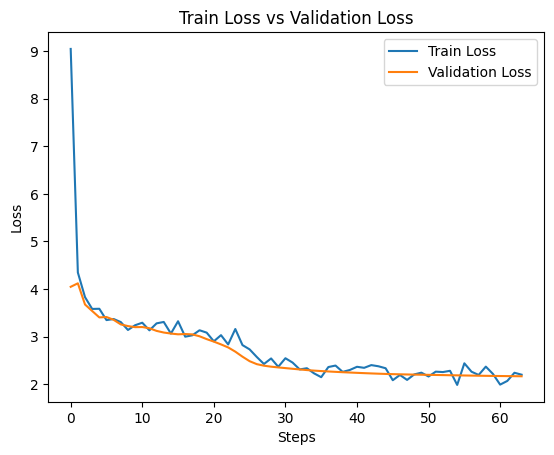

In [9]:
# Plot train losses and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.show()

In [7]:
# Checkpointing
############################

PATH = './MyFiles/'
#save_checkpoint = checkpoint(model,optimizer,path=PATH,save_name="checkpoint_dicts")
#torch.save(model, PATH+'model.pt')
#model_state, optimizer_state = load_checkpoint(PATH+"checkpoint_dicts.pt")

#pickle_dump(train_losses,PATH,"train_losses.pkl")
#pickle_dump(val_losses,PATH,"val_losses.pkl")

model = torch.load(PATH+'model.pt')
#train_losses = pickle_load(PATH+"train_losses.pkl")
#val_losses = pickle_load(PATH+"val_losses.pkl")

In [10]:
model.load_state_dict(model_state)
optimizer.load_state_dict(optimizer_state)

In [ ]:
# Gradient accumulation hugging face training
############################
train_losses, val_losses, model = train_ga_hf(epochs, model, optimizer, criterion, train_loader, val_loader, device, lr_scheduler, accumulation_steps)

In [ ]:
if __name__ == "__main__":
    # !!! Don't change the seed !!!
    torch.manual_seed(42)
    # !!!!!!

    # Download the data

    # SAVE and put the code above into a function that you will call if you need to generate something slightly different
    PATH = './MyFiles/'
    #pairs = create_pairs(path=PATH,savename1="pre_pairs",savename2="pairs",max_length=26,word_frequency_discard=10,verbose=False)
    pairs = pickle_load(PATH+'pairs.pkl')

    # Training loop (Consider writing a function for this/two separate functions for training and validation)

    # Evaluation by feeding the model with one input sentence at a time
